In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import cv2
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import glob
import time

from scipy.ndimage.measurements import label

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Classes for image feature extraction and object detection

In [8]:
class ImageFeatureExtractor(object):
    """
    Extract features from images using:
     - Histogram of Oriented Gradients (HOG)
     - Spatial Binning
     - Colour Histogram
    """
    def __init__(self, config):
        self.config = config
        
    def extract_features(self, image, visualise=False):
        """
        Extract features from an image.
        
        :param image: Image array (e.g. mpimg.imread())
        :return: Extracted features as one long feature vector
        """
        # Create a list to append feature vectors to
        features = []
        test_image = []
        
        if np.max(image) > 1:
            image = image.astype(np.float32) / float(np.max(image))
        
        # apply color conversion if other than 'RGB'
        if self.config['color_space'] != 'RGB':
            if self.config['color_space'] == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif self.config['color_space'] == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif self.config['color_space'] == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif self.config['color_space'] == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif self.config['color_space'] == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
        
        if self.config['spatial_feat'] == True:
            spatial_features = self.bin_spatial(feature_image)
            features.append(spatial_features)
            
        if self.config['hist_feat'] == True:
            # Apply color_hist()
            hist_features = self.color_hist(feature_image)
            features.append(hist_features)
        
        if self.config['hog_feat'] == True:
            if self.config['hog_channel'] == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_feature, test_image = self.get_hog_features(feature_image[:, :, channel], visualise)
                    hog_features.append(hog_feature)
                                                        
                hog_features = np.ravel(hog_features)
            else:
                hog_features, test_image = self.get_hog_features(feature_image[:, :, hog_channel], visualise)
            
            # Append the new feature vector to the features list
            features.append(hog_features)
        
        # Return list of feature vectors
        return np.concatenate(features), test_image
    
    def bin_spatial(self, img):
        size = self.config['spatial_size']
        color1 = cv2.resize(img[:,:,0], size).ravel()
        color2 = cv2.resize(img[:,:,1], size).ravel()
        color3 = cv2.resize(img[:,:,2], size).ravel()
        return np.hstack((color1, color2, color3))
    
    def color_hist(self, img):
        nbins = self.config['hist_bins'] #bins_range=(0, 256)
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    def get_hog_features(self, image, visualise):
        features, image = hog(image,
                       orientations=self.config['orient'], 
                       pixels_per_cell=(self.config['pix_per_cell'], self.config['pix_per_cell']),
                       cells_per_block=(self.config['cell_per_block'], self.config['cell_per_block']), 
                       transform_sqrt=False, 
                       visualise=visualise,
                       feature_vector=True)
        
        return features, image

        
class ObjectDetector(object):
    """
    Detect objects in an image using the provided image
    feature extractor and a trained Linear SVM classifier.
    """
    def __init__(self, config, sliding_window_config, classifier, standard_scaler):
        """
        """
        self.config = config
        self.sliding_window_config = sliding_window_config
        self.classifier = classifier
        self.standard_scaler = standard_scaler
        #self.heatmap = []
        #self.windows = []
        
    def process(self, image):
        """
        """
        global heat
        global windows
        
        draw_image = np.copy(image)
        original_image = np.copy(image)
        
        if np.max(image) > 1:
            image = image.astype(np.float32) / float(np.max(image))
        
        windows = self.get_pyramid_windows(image)
        hot_windows = self.find_objects(image, windows)
        window_img = self.draw_boxes(draw_image, hot_windows)
        # new heatmap
        heat = np.zeros_like(window_img[:, :, 0]).astype(np.float)
        heatmap = self.add_heat(heat, hot_windows)
        heatmap = self.threshold_heatmap(heatmap, self.sliding_window_config['heat_threshold'])
        # Blob extraction
        # Implements: https://en.wikipedia.org/wiki/Connected-component_labeling
        labels = label(heatmap)
        output_image = self.draw_labeled_bboxes(original_image, labels)
        return output_image
    
    def find_objects(self, img, windows):
        """
        """
        # Define a function you will pass an image
        # and the list of windows to be searched (output of slide_windows())
        #def search_windows(img, windows, clf, scaler, color_space='RGB',
        #           spatial_size=(32, 32), hist_bins=32,
        #           hist_range=(0, 256), orient=9,
        #           pix_per_cell=8, cell_per_block=2,
        #           hog_channel=0, spatial_feat=True,
        #           hist_feat=True, hog_feat=True):
        
        on_windows = []
        for window in windows:
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
            features = ImageFeatureExtractor(self.config).extract_features(test_img)
            test_features = self.standard_scaler.transform(np.array(features).reshape(1, -1))
            prediction = self.classifier.predict(test_features)
            if prediction == 1:
                on_windows.append(window)
            
        return on_windows
    
    def get_pyramid_windows(self, image):
        """
        Was average_sliding_windows()
        
        Repeatedly get sliding windows for different window sizes.
        This will allow our detector to find smaller and larger sized
        objects.
        """
        windows = []
        for xy in self.sliding_window_config['window_sizes']: #[64, 96, 140]:
            window = self.get_sliding_windows(image, xy_window=(xy, xy))
            windows += window
        return windows
    
    # Define a function that takes an image,
    # start and stop positions in both x and y,
    # window size (x and y dimensions),
    # and overlap fraction (for both x and y)
    def get_sliding_windows(self, img, xy_window):
        """
        Implementation of the sliding-window technique.
        Return a list of windows (rectangles) that have been moved over
        the image with the given size and configured overlap and start/stop
        positions.
        
        slide_window()
        """
        # If x and/or y start/stop positions not defined, set to image size
        if self.sliding_window_config['x_start_stop'][0] == None:
            self.sliding_window_config['x_start_stop'][0] = 0
        if self.sliding_window_config['x_start_stop'][1] == None:
            self.sliding_window_config['x_start_stop'][1] = img.shape[1]
        if self.sliding_window_config['y_start_stop'][0] == None:
            self.sliding_window_config['y_start_stop'][0] = 0
        if self.sliding_window_config['y_start_stop'][1] == None:
            self.sliding_window_config['y_start_stop'][1] = img.shape[0]
    
        xspan = self.sliding_window_config['x_start_stop'][1] - self.sliding_window_config['x_start_stop'][0]
        yspan = self.sliding_window_config['y_start_stop'][1] - self.sliding_window_config['y_start_stop'][0]
        nx_pix_per_step = np.int(xy_window[0] * (1 - self.sliding_window_config['xy_overlap'][0]))
        ny_pix_per_step = np.int(xy_window[1] * (1 - self.sliding_window_config['xy_overlap'][1]))
        nx_windows = np.int(xspan / nx_pix_per_step) - 1
        ny_windows = np.int(yspan / ny_pix_per_step) - 1
        window_list = []
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs * nx_pix_per_step + self.sliding_window_config['x_start_stop'][0]
                endx = startx + xy_window[0]
                starty = ys * ny_pix_per_step + self.sliding_window_config['y_start_stop'][0]
                endy = starty + xy_window[1]
                window_list.append(((startx, starty), (endx, endy)))
        return window_list
    
    def draw_boxes(self, img, bboxes, color=(0, 25, 255), thick=6):
        """
        Draw the given bounding boxes on the image
        """
        imcopy = np.copy(img)
        for bbox in bboxes:
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        return imcopy
    
    def add_heat(self, heatmap, bbox_list):
        """
        Build up a heat map image from the given bounding
        boxes. We add +1 for each pixel within the bounding 
        box.
        """
        for box in bbox_list:
            heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        return heatmap
    
    def threshold_heatmap(self, heatmap, threshold=1):
        """
        Zero out pixels in the provided image below the given threshold
        
        :param heatmap: Heatmap array - same size as image
        :param threshold: The threhold value below which pixes are zeroed
        :return: Extracted features as one long feature vector
        """
        heatmap[heatmap <= threshold] = 0
        return heatmap
    
    def draw_labeled_bboxes(self, img, labels):
        """
        """
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0, 25, 255), 6)
        # Return the image
        return img

## Setup our processing configurations for extracing features and operating the sliding windows
Note: I have currently fine-tuned these parameters with the aim of good stable detections and *not* fast processing...

In [9]:
feature_config = {
    'color_space' : 'YCrCb',
    'orient' : 9,
    'pix_per_cell' : 8,
    'cell_per_block' : 2,
    'hog_channel' : 'ALL',
    'spatial_size' : (32, 32),
    'hist_bins' : 32,
    'spatial_feat' : True,
    'hist_feat' : True,
    'hog_feat' : True
}

sliding_windows_config = {
    'xy_overlap' : (0.8, 0.8),
    'xy_window' : [64, 64],
    'y_start_stop' : [340, 680],
    'x_start_stop' : [760, 1260],
    'window_sizes' : [64, 96, 140],
    'heat_threshold' : 2
}

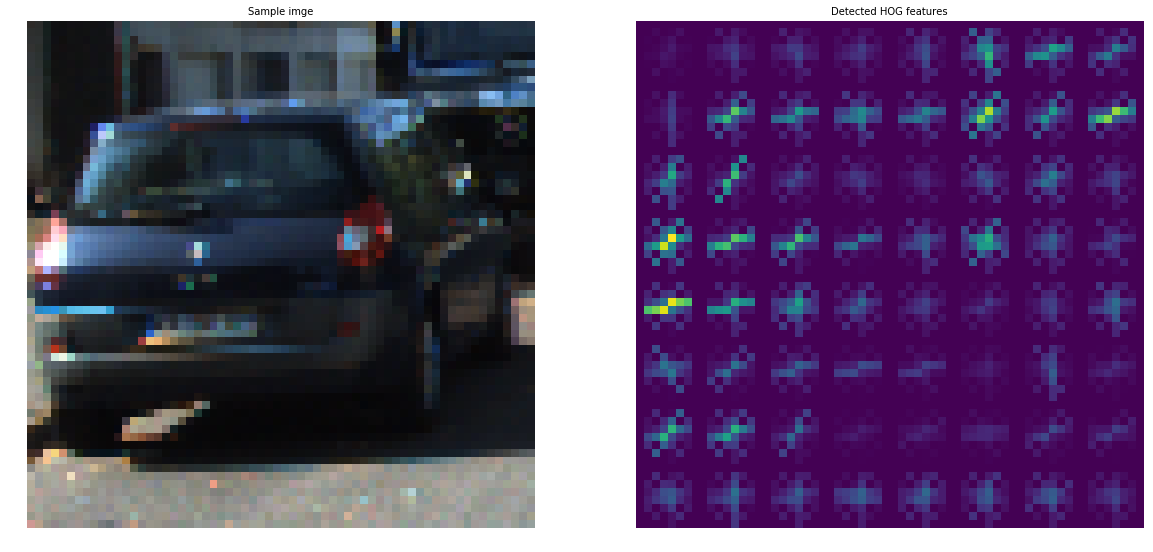

In [15]:
test_image = mpimg.imread('/Users/jason/repos/CarND-Vehicle-Detection/data/vehicles/KITTI_extracted/22.png')
ife = ImageFeatureExtractor(feature_config)
test_features, img = ife.extract_features(test_image, True)
del ife

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Sample imge', fontsize=10)
ax1.axis('off')

ax2.imshow(img)
ax2.set_title('Detected HOG features', fontsize=10)
ax2.axis('off');

## Read our dataset, extract features and train a Linear SVM classifier

In [ ]:
MODE = 'TRAIN'
if MODE == 'TRAIN':
    print('Extracting features...')
    t=time.time()
    
    ife = ImageFeatureExtractor(feature_config)
    
    # Divide up into cars and notcars
    cars = glob.glob('data/vehicles/*/*.png')
    notcars = glob.glob('data/non-vehicles/*/*.png')
    
    car_features = []
    notcar_features = []
    
    for file in cars:
        image = mpimg.imread(file)
        car_feature = ife.extract_features(image)
        car_features.append(car_feature)
    
    for file in notcars:
        image = mpimg.imread(file)
        notcar_feature = ife.extract_features(image)
        notcar_features.append(notcar_feature)
    
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features...')
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    
    print('Using:', feature_config['orient'], 'orientations', feature_config['pix_per_cell'],
        'pixels per cell and', feature_config['cell_per_block'], 'cells per block')
    print('Feature vector length:', len(X_train[0]))
    
    # Use a linear SVC
    print('\nTraining classifier...')
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these', n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

## Display test images with detected object bounding boxes and heatmaps
This is to fine-tune our config parameters to reduce false-positives

In [ ]:
print('Processing test images...')
glob_test_images = glob.glob('test_images/*.jpg')

for file in glob_test_images:
    image = mpimg.imread(file)
    
    if np.max(image) > 1:
        image = image.astype(np.float32) / float(np.max(image))
    
    draw_image = np.copy(image)
    
    detector = ObjectDetector(feature_config, sliding_windows_config, svc, X_scaler)
    
    windows = detector.get_pyramid_windows(image)
    
    hot_windows = detector.find_objects(image, windows)
    
    window_img = detector.draw_boxes(draw_image, hot_windows, color=(0, 25, 255), thick=6)
    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
    
    heatmap = detector.add_heat(heat, hot_windows)
    heatmap = detector.threshold_heatmap(heatmap, threshold=2)
    
    # Blob extraction
    # Implements: https://en.wikipedia.org/wiki/Connected-component_labeling
    labels = label(heatmap)
    output_image = detector.draw_labeled_bboxes(draw_image, labels)
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
    ax1.imshow(window_img)
    ax1.set_title('Found bounding boxes', fontsize=10)
    ax1.axis('off')
    
    ax2.imshow(labels[0], cmap='hot')
    ax2.set_title('Blob extraction {} objects'.format(labels[1]), fontsize=10)
    ax2.axis('off')
    
    ax3.imshow(heatmap, cmap='hot')
    ax3.set_title('Heatmap as an image', fontsize=10)
    ax3.axis('off')
    
    ax4.imshow(output_image)
    ax4.set_title('Heatmap converted to bounding box')
    ax4.axis('off')

## Test the pipeline on the test images and display the results

In [ ]:
glob_test_images = glob.glob('test_images/*.jpg')
del detector
detector = ObjectDetector(feature_config, sliding_windows_config, svc, X_scaler)

for file in glob_test_images:
    image = mpimg.imread(file)
    plt.imshow(detector.process(image))
    plt.axis('off')
    plt.show()

## Now apply the pipeline to the test videos

In [ ]:
del detector
detector = ObjectDetector(feature_config, sliding_windows_config, svc, X_scaler)

video_output = 'output_images/project_video_output.mp4'
#clip1 = VideoFileClip('project_video.mp4')
clip1 = VideoFileClip('test_video.mp4')
clip1_output = clip1.fl_image(detector.process) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))